#Rugby Player Position Classification

The aim of this notebook is to see if it is possible to classify rugby players by position using data taken from the <a href="http://www.rugbyworldcup.com/" target="_blank">Rugby World Cup</a> website. <a href="http://www.anquantarbuile.com/static/images/plots/RWC2015semisheightweight.png" target="_blank">This plot</a> shows the squad members of the RWC semi-finalists plotted by country and position. The second plot show that some positions should be easy to predict based on height and weight, such as Prop, Lock and Hooker while Fly Half, Full Back and Wing would be a lot harder. I want to see if the addition of data on points and tries scored will help.

The data below is taken from the bigger Rugby playing nations and was pulled down from the RWC website the day after the Final.

In [1]:
import pandas as pd
import numpy as np

In [2]:
argentina = pd.read_csv('argentina.csv')
australia = pd.read_csv('australia.csv')
england = pd.read_csv('england.csv')
france = pd.read_csv('france.csv')
georgia = pd.read_csv('georgia.csv')   
ireland = pd.read_csv('ireland.csv')
italy = pd.read_csv('italy.csv')  
new_zealand = pd.read_csv('new-zealand.csv')
scotland = pd.read_csv('scotland.csv')
south_africa = pd.read_csv('south-africa.csv')
wales = pd.read_csv('wales.csv')

frames = [argentina, australia, england, france, ireland, italy, new_zealand,
          scotland, south_africa, wales]
combined = pd.concat(frames).reset_index(drop = True) #create single dataframe containing all players

In [3]:
#The Italian names seem to be causing the second Name column to appear, I didn't handle this when pulling down the data. 

#Clean Height and Weight columns, calculate Mass of players
combined['Height'] = combined['Height'].map(lambda x: x.strip('cm')).astype(int)
combined['Weight'] = combined['Weight'].map(lambda x: x.strip('kg')).astype(int)
combined["Mass"] = (combined["Height"]/100) * combined["Weight"]


#Assign each position a numeric target to be predicted ie 0 = Back Row
combined["Target"] = 0
for i, position in enumerate(np.unique(combined["Position"])):
    combined["Target"][combined["Position"] == position] = i

combined.head()

C:\Users\maniacalbrain\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Age,Debut,Height,Matches,Name,Points_Scored,Position,Red_Cards,Tries_Scored,Weight,Yellow_Cards,﻿Name,Mass,Target
0,23,17 May 2014,198,20,Matias Alemanno,10,Lock,0,2,112,0,NaN,221.76,5
1,32,04 Dec 2004,186,65,Marcos Ayerza,5,Prop,0,1,113,1,NaN,210.18,6
2,30,23 Apr 2005,182,46,Agustín Creevy,10,Hooker,0,2,106,0,NaN,192.92,4
3,32,08 Nov 2008,190,20,Juan Pablo Orlandi,5,Prop,0,1,119,0,NaN,226.10,6
4,33,28 Apr 2004,191,71,Juan Martín Fernandez Lobbe,25,Back Row,0,5,106,2,NaN,202.46,0


In [4]:
#Zip the target values to the position values. This can be used later when looking at confusion matrix data
pos_to_tar = zip(np.unique(combined.Target), np.unique(combined.Position))
print pos_to_tar

[(0, 'Back Row'), (1, 'Centre'), (2, 'Fly Half'), (3, 'Full Back'), (4, 'Hooker'), (5, 'Lock'), (6, 'Prop'), (7, 'Scrum Half'), (8, 'Wing')]


I now need to deceide what data is and isn't useful. Name, Age and Debut are dropped. A players position doesn't depend on how many games they have played so this will be dropped as well but first will be used to create some new columns. Two player could play in the same position but one could have scored twice as many points if they have played twice as many games. Therefore I create columns for average points per game and average tries per game and then drop the absolute points, tries and matches column. 

The remaining columns are then normalised and scaled

An area I didn't look into was differences between countries. Two players could play in the same position but one could have scored twice as many points if he plays for New-Zealand and the other plays for England. Even their average scores would be different, New-Zealand players scoring more on average. Something to look at would be normalisng and scaling the values of each country seperatly before combining all the countries to make a single dataframe so that the highest scoring player of each country would have a simulare number even if one averaged half as many points as another.

Two "test rows" are added containing the data of two retired players. At the end the model will be fitted with all the data and asked to predict the positions they played in based on their career data.

In [5]:
#Create a single dataframe containing the useful data.

to_merge = [combined.Height, combined.Weight, combined.Matches, combined.Points_Scored, combined.Tries_Scored, combined.Mass, combined.Target]
combined = pd.concat(to_merge, axis = 1)

#Add two rows to be predicted afterwards
test_rows = pd.DataFrame([[178, 93, 133, 245, 46, 165.54, np.nan],
                        [183, 83, 128, 1083, 16, 151.89, np.nan]],
                        columns = list(combined.columns))

combined = combined.append(test_rows).reset_index(drop=True)

combined.tail()

,Height,Weight,Matches,Points_Scored,Tries_Scored,Mass,Target
327,184,90,3,4,0,165.60,3
328,183,95,81,352,13,173.85,1
329,184,91,1,0,0,167.44,8
330,178,93,133,245,46,165.54,NaN
331,183,83,128,1083,16,151.89,NaN


In [6]:
#Calculate Average points per game and Average tries per game
combined["Avg_Pts"] = combined.Points_Scored.astype("float")/combined.Matches.astype("float")
combined["Avg_Tries"] = combined.Tries_Scored.astype("float")/combined.Matches.astype("float")
combined.head()

,Height,Weight,Matches,Points_Scored,Tries_Scored,Mass,Target,Avg_Pts,Avg_Tries
0,198,112,20,10,2,221.76,5,0.500000,0.100000
1,186,113,65,5,1,210.18,6,0.076923,0.015385
2,182,106,46,10,2,192.92,4,0.217391,0.043478
3,190,119,20,5,1,226.10,6,0.250000,0.050000
4,191,106,71,25,5,202.46,0,0.352113,0.070423


In [7]:
#Some players have played no games and will end up with null values after the above division. Set these values to 0. 

combined.Avg_Pts = combined.Avg_Pts.fillna(0)
combined.Avg_Tries = combined.Avg_Tries.fillna(0)

In [8]:
#Drop mathes, points and tries scored

combined=combined.drop(["Matches", "Points_Scored", "Tries_Scored"], axis = 1)
combined.head()

,Height,Weight,Mass,Target,Avg_Pts,Avg_Tries
0,198,112,221.76,5,0.500000,0.100000
1,186,113,210.18,6,0.076923,0.015385
2,182,106,192.92,4,0.217391,0.043478
3,190,119,226.10,6,0.250000,0.050000
4,191,106,202.46,0,0.352113,0.070423


In [9]:
#Create normalized and scaled transformations of the remaining values.
to_transform = ["Height", "Weight", "Mass", "Avg_Pts", "Avg_Tries"]
for factor in to_transform:
    factor_norm = factor + "_norm"
    factor_scale = factor + "_scaled"
    combined[factor_norm] = (combined[factor] - combined[factor].mean()) / (combined[factor].max() - combined[factor].min())
    combined[factor_scale] = (combined[factor] - combined[factor].min()) / combined[factor].max()
    
combined.head()

,Height,Weight,Mass,Target,Avg_Pts,Avg_Tries,Height_norm,Height_scaled,Weight_norm,Weight_scaled,Mass_norm,Mass_scaled,Avg_Pts_norm,Avg_Pts_scaled,Avg_Tries_norm,Avg_Tries_scaled
0,198,112,221.76,5,0.500000,0.100000,0.264179,0.149038,0.105502,0.289655,0.156322,0.367093,-0.043478,0.035044,-0.027454,0.100000
1,186,113,210.18,6,0.076923,0.015385,-0.028504,0.091346,0.118835,0.296552,0.087700,0.326553,-0.073130,0.005391,-0.112070,0.015385
2,182,106,192.92,4,0.217391,0.043478,-0.126065,0.072115,0.025502,0.248276,-0.014581,0.266130,-0.063285,0.015236,-0.083976,0.043478
3,190,119,226.10,6,0.250000,0.050000,0.069057,0.110577,0.198835,0.337931,0.182041,0.382286,-0.061000,0.017522,-0.077454,0.050000
4,191,106,202.46,0,0.352113,0.070423,0.093447,0.115385,0.025502,0.248276,0.041952,0.299527,-0.053843,0.024679,-0.057032,0.070423


In [10]:
#Create a dataframe to hold the two test_rows and remove them from the combined dataframe

test_rows = combined[combined.Target.isnull()]
combined = combined[combined.Target.notnull()]

In [11]:
#Extract the target values and drop them from combined and test_row dataframes. These are now ready to be used in a classifier

target = combined.Target
combined = combined.drop(["Target"], axis = 1)
test_rows = test_rows.drop(["Target"], axis = 1)

combined.head()

,Height,Weight,Mass,Avg_Pts,Avg_Tries,Height_norm,Height_scaled,Weight_norm,Weight_scaled,Mass_norm,Mass_scaled,Avg_Pts_norm,Avg_Pts_scaled,Avg_Tries_norm,Avg_Tries_scaled
0,198,112,221.76,0.500000,0.100000,0.264179,0.149038,0.105502,0.289655,0.156322,0.367093,-0.043478,0.035044,-0.027454,0.100000
1,186,113,210.18,0.076923,0.015385,-0.028504,0.091346,0.118835,0.296552,0.087700,0.326553,-0.073130,0.005391,-0.112070,0.015385
2,182,106,192.92,0.217391,0.043478,-0.126065,0.072115,0.025502,0.248276,-0.014581,0.266130,-0.063285,0.015236,-0.083976,0.043478
3,190,119,226.10,0.250000,0.050000,0.069057,0.110577,0.198835,0.337931,0.182041,0.382286,-0.061000,0.017522,-0.077454,0.050000
4,191,106,202.46,0.352113,0.070423,0.093447,0.115385,0.025502,0.248276,0.041952,0.299527,-0.053843,0.024679,-0.057032,0.070423


##Fitting a Random Forest Classification

We now have the values we are going to use for classification. However we have both height, weight and mass, the latter a value found by combining the first two. So the information held by this value is also held in the first two. On some runs of the below classifiers I found height and weight to always be a small bit more important then mass so in the below I will drop mass.

I will create three data frames from the original, one for the starting or simple values, one for the normalized values and one for the scaled values. I will then convert these and the target values to an np.array as required by the classifiers.

I used both logistic regressors and a gradient boosting regressor but found better results with the random forest and will used that below. It may be worth trying an Extra Trees Classifier, AdaBoosting or Naive Bayes. 

In [12]:
#Create 3 dataframes with the relevent data
simple_values = [combined['Height'], combined['Weight'],  combined['Avg_Pts'], combined['Avg_Tries']]
norm_values = [combined['Height_norm'], combined['Weight_norm'],  combined['Avg_Pts_norm'], combined['Avg_Tries_norm']]
scale_values = [combined['Height_scaled'], combined['Weight_scaled'],  combined['Avg_Pts_scaled'], combined['Avg_Tries_scaled']]

simple_df = pd.concat(simple_values, axis=1)
norm_df = pd.concat(norm_values, axis = 1)
scale_df = pd.concat(scale_values, axis = 1)

#convert each dataframe to an np.array
simple_X = simple_df.values
norm_X = norm_df.values
scale_X = scale_df.values

#convert target to np.array
Y = target.values

First I create a random forest classifier for each of the 3 X values and carry out cross validation as there is so little data. It is often best to set n_estimators to a high value on random forests so I start at 2000.

In [13]:
#Important imports
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
% pylab inline

from sklearn.ensemble import RandomForestClassifier

simple_rfc = RandomForestClassifier(n_estimators=2000)
scores = cross_val_score(simple_rfc, simple_X, Y, cv = 5)
print scores.mean()
print scores.std()

print ""

norm_rfc = RandomForestClassifier(n_estimators=2000)
scores = cross_val_score(norm_rfc, norm_X, Y, cv = 5)
print scores.mean()
print scores.std()

print ""

scale_rfc = RandomForestClassifier(n_estimators=2000)
scores = cross_val_score(scale_rfc, scale_X, Y, cv = 5)
print scores.mean()
print scores.std()

Populating the interactive namespace from numpy and matplotlib
0.648639459077
0.0542635555778

0.632830001236
0.041490754897

0.642165477851
0.0424758937055


The numbers are very similar, averaging at 63-64% accuracy, which over 9 classes isn't that bad. Random guessing would give us a baseline of 11%! The highest value returned above is for the simple model but over repeated runnings the scaled model often performs better and returns a lower standered deviation. This is the model I'm going to use below but this show it is important to carry out multiple runs to find which model consistantly returns the best values. It is also worth weighing up what you want from a model, high accuracy or low standard deviation. 

Below I will fit an RFC with all the avalible data to calculate the feature importances. As I am using scale_rfc from above this has 2000 estimators.

In [17]:
scale_rfc.fit(scale_X,Y)
sorted(zip(scale_df.columns, scale_rfc.feature_importances_),key=lambda x: x[1], reverse=True)

[('Weight_norm', 0.31216546498106323),
 ('Height_norm', 0.31096799076471909),
 ('Avg_Pts_norm', 0.20838441127001803),
 ('Avg_Tries_norm', 0.1684821329842007)]

Weight and Height are very important for predicting a players position, making up 62% of the model. Now I'll use a confusion matrix to see which positions the model is predicting well and which it is not. To do this I will need to predict data for a number of rows. I will need to fit an rfc with a portion of the dataframe and then get it to predict the remaining portion. The confusion matrix will then compare these predicted values to the real values.

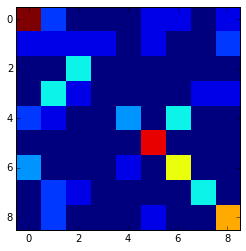

In [14]:
x_train, x_test, y_train, y_test = train_test_split(scale_X, Y)

scale_rfc.fit(x_train, y_train)
scale_pred = scale_rfc.predict(x_test)
scale_rfc_cm = confusion_matrix(y_test, scale_pred)
plt.imshow(scale_rfc_cm, interpolation='nearest')

In [15]:
print pos_to_tar

[(0, 'Back Row'), (1, 'Centre'), (2, 'Fly Half'), (3, 'Full Back'), (4, 'Hooker'), (5, 'Lock'), (6, 'Prop'), (7, 'Scrum Half'), (8, 'Wing')]


In [16]:
scale_rfc_cm

array([[11,  2,  0,  0,  0,  1,  1,  0,  1],
       [ 1,  1,  1,  1,  0,  1,  0,  0,  2],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  1,  0,  0,  0,  0,  1,  1],
       [ 2,  1,  0,  0,  3,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 3,  0,  0,  0,  1,  0,  7,  0,  0],
       [ 0,  2,  1,  0,  0,  0,  0,  4,  0],
       [ 0,  2,  0,  0,  0,  1,  0,  0,  8]])

Both the plotted and numeric version of the confusion matrix are shown above with the positions mapped to their targets. The model is getting every single Lock correct (5th row, with 0th row at the top) and is getting every single Full Back wrong, thinking that they are all Centres(3rd row). Centre and Hooker are also poor.

Below is a classification report. To help read it used row 6 (Prop) above and remember:
True Positive: Times model predicted correctly (predicted Prop, was Prop = 7)

False Positive: Times model predicted a position when it wasn't that position. Sum of incorrect values in a column. (Predicted Prop, wasn't: 1 back row and 4 hookers predicted as prop = 5)

False Negative: Times model predicted a specific position to be other then it was. Sum of incorrect values in a row (Was a Prop but predicted otherwise: 3 props predicted as Back Row, 1 as Hooker = 4)

Precision = tp/(tp+fp) = 7/(7+5) = 0.583 - If the model guesses Prop what percentage of the time is it right
Recall = tp/(tp+fn) = 7/(7+4) = 0.636 - What percentage of Props did I guess correctly

f1-score = 2 x (precision x recall)/ (precision + recall) = 2 x (0.583 x 0.636) / (0.583 + 0.636) = 0.608
This can be considered a weighted average of the precision and recall scores. Higher the better!

In [17]:
from sklearn.metrics import classification_report 
positions = ["Back Row", "Centre", "Fly Half", "Full Back", "Hooker", "Lock", "Prop", "Scrum Half", "Wing"]
print classification_report(y_test, scale_pred, target_names=positions)

             precision    recall  f1-score   support

   Back Row       0.65      0.69      0.67        16
     Centre       0.08      0.14      0.11         7
   Fly Half       0.57      1.00      0.73         4
  Full Back       0.00      0.00      0.00         7
     Hooker       0.75      0.30      0.43        10
       Lock       0.77      1.00      0.87        10
       Prop       0.58      0.64      0.61        11
 Scrum Half       0.80      0.57      0.67         7
       Wing       0.67      0.73      0.70        11

avg / total       0.58      0.58      0.56        83



Centre, Full-Back and Hooker are pretty rubbish. We have a very big tendency to predict things as centre when they aren't where as we only do this a few times with scrum-halfs (Precision). The model got all the locks and Fly-Halfs right but didn't get a single ful back. Surprise, surprise, looking at our confusion matrix above we see it thought most of them were centres.

Below I do a very limited GridSearch to find some paramaters to imporve the model

In [18]:
from sklearn.grid_search import GridSearchCV

params = {
    'n_estimators' : [1000, 2000, 3000],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1,2,3,4, None]
}

est = RandomForestClassifier()
grid_search = GridSearchCV(est, params, verbose=5).fit(x_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

print best_parameters

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=1000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=1, score=0.482353 -   2.1s
[CV] n_estimators=1000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=1, score=0.451220 -   2.1s
[CV] n_estimators=1000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=1, score=0.487500 -   2.1s
[CV] n_estimators=2000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=1, score=0.494118 -   4.7s
[CV] n_estimators=2000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=1, score=0.451220 -   4.4s
[CV] n_estimators=2000, criterion=gini, max_depth=1 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=1, score=0.500000 -   4.3s
[CV] n_estimators=3000, criterion=gini, max_d

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  18 jobs       | elapsed:  1.3min



[CV] n_estimators=1000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=3, score=0.576471 -   2.3s
[CV] n_estimators=1000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=3, score=0.621951 -   2.2s
[CV] n_estimators=1000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=1000, criterion=gini, max_depth=3, score=0.725000 -   2.2s
[CV] n_estimators=2000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=3, score=0.576471 -   4.5s
[CV] n_estimators=2000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=3, score=0.609756 -   4.5s
[CV] n_estimators=2000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=2000, criterion=gini, max_depth=3, score=0.750000 -   4.5s
[CV] n_estimators=3000, criterion=gini, max_depth=3 ..................
[CV]  n_estimators=3000, criterion

[Parallel(n_jobs=1)]: Done  72 jobs       | elapsed:  5.8min
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  7.6min finished



Best score: 0.684
Best parameters set:
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 2000, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'auto', 'max_depth': 4, 'class_weight': None}


In [19]:
best_rfc = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=4)
scores = cross_val_score(norm_rfc, scale_X, Y, cv=5)

print scores.mean()
print scores.std()

best_rfc.fit(scale_X,Y)
sorted(zip(scale_df.columns, best_rfc.feature_importances_),key=lambda x: x[1], reverse=True)

0.642389459077
0.0548238242228


[('Height_scaled', 0.35439390620415961),
 ('Weight_scaled', 0.34646337512205938),
 ('Avg_Pts_scaled', 0.1850060129023165),
 ('Avg_Tries_scaled', 0.11413670577146463)]

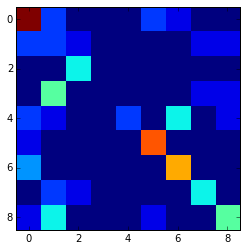

In [20]:
best_rfc.fit(x_train, y_train)
best_rfc_pred = best_rfc.predict(x_test)
best_rfc_cm = confusion_matrix(y_test, best_rfc_pred)
plt.imshow(best_rfc_cm, interpolation='nearest')

In [21]:
best_rfc_cm

array([[11,  2,  0,  0,  0,  2,  1,  0,  0],
       [ 2,  2,  1,  0,  0,  0,  0,  1,  1],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  1,  1],
       [ 2,  1,  0,  0,  2,  0,  4,  0,  1],
       [ 1,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  8,  0,  0],
       [ 0,  2,  1,  0,  0,  0,  0,  4,  0],
       [ 1,  4,  0,  0,  0,  1,  0,  0,  5]])

In [23]:
print classification_report(y_test, best_rfc_pred, target_names=positions);

             precision    recall  f1-score   support

   Back Row       0.55      0.69      0.61        16
     Centre       0.12      0.29      0.17         7
   Fly Half       0.67      1.00      0.80         4
  Full Back       0.00      0.00      0.00         7
     Hooker       1.00      0.20      0.33        10
       Lock       0.75      0.90      0.82        10
       Prop       0.62      0.73      0.67        11
 Scrum Half       0.67      0.57      0.62         7
       Wing       0.62      0.45      0.53        11

avg / total       0.58      0.54      0.52        83



Not much of a change, indeed the gridsearched model has a lower recall and f1-score then the basic model (though all that has changed is max depth). Lets see how it applies to predicted the two test players. test_rows currently contains all the columns so first we create a dataframe that only has the scaled columns.

In [24]:
scale_values = [test_rows['Height_scaled'], test_rows['Weight_scaled'],  test_rows['Avg_Pts_scaled'], test_rows['Avg_Tries_scaled']]

test_rows_df = pd.concat(scale_values, axis = 1)

test_rows_X = test_rows_df.values

In [25]:
scale_rfc.fit(scale_X, Y)
test_pred = scale_rfc.predict(test_rows_X)
test_proba = scale_rfc.predict_proba(test_rows_X)
print "Random Forest Classifer - No GridSearch"
print "Name\t\t Position\t Prediction\t Probability"
print "Brian O'Driscoll Centre\t\t %s\t\t %0.2f\nRonan O'Gara\t Fly-Half\t %s\t %0.2f" % (positions[int(test_pred[0])], max(test_proba[0]), positions[int(test_pred[1])], max(test_proba[1]))

print ""
best_rfc.fit(scale_X, Y)
test_pred2 = best_rfc.predict(test_rows_X)
test_proba2 = best_rfc.predict_proba(test_rows_X)
print "Random Forest Classifer - Using BestGrid Search Parameters"
print "Name\t\t Position\t Prediction\t Probability"
print "Brian O'Driscoll Centre\t\t %s\t\t %0.2f\nRonan O'Gara\t Fly-Half\t %s\t %0.2f" % (positions[int(test_pred2[0])], max(test_proba2[0]), positions[int(test_pred2[1])], max(test_proba2[1]))

Random Forest Classifer - No GridSearch
Name		 Position	 Prediction	 Probability
Brian O'Driscoll Centre		 Wing		 0.80
Ronan O'Gara	 Fly-Half	 Fly Half	 0.84

Random Forest Classifer - Using BestGrid Search Parameters
Name		 Position	 Prediction	 Probability
Brian O'Driscoll Centre		 Wing		 0.53
Ronan O'Gara	 Fly-Half	 Fly Half	 0.65


Both times our models predict Brian O'Driscoll to be a Wing but they both get O'Gara correct. What is different though is the probability or certinty each model predicts for each position. The first model is 80% certin O'Driscoll is a Wing where as the second is 53%. There is also a big drop in certinty for O'Gara. Below is the probability each model assigned each player for each position.

In [26]:
print "Probabilities for Brian O'Driscoll"
print "No GridSearch"
sorted(zip(positions,test_proba[0]),key=lambda x: x[1], reverse=True)

Probabilities for Brian O'Driscoll
No GridSearch


[('Wing', 0.79749999999999999),
 ('Centre', 0.062),
 ('Scrum Half', 0.061499999999999999),
 ('Fly Half', 0.032500000000000001),
 ('Full Back', 0.031),
 ('Hooker', 0.0089999999999999993),
 ('Back Row', 0.0064999999999999997),
 ('Lock', 0.0),
 ('Prop', 0.0)]

In [27]:
print "GridSearched"
sorted(zip(positions,test_proba2[0]),key=lambda x: x[1], reverse=True)

GridSearched


[('Wing', 0.53435193401178072),
 ('Centre', 0.1822288294254821),
 ('Scrum Half', 0.099770383938151491),
 ('Fly Half', 0.072088939819069539),
 ('Full Back', 0.056671908659138744),
 ('Back Row', 0.028130221683530403),
 ('Hooker', 0.025340993720654362),
 ('Prop', 0.0013582177982544544),
 ('Lock', 5.8570943939277372e-05)]

In [28]:
print "Probabilities for Ronan O'Gara"
print "No GridSearch"

sorted(zip(positions,test_proba[1]),key=lambda x: x[1], reverse=True)

Probabilities for Ronan O'Gara
No GridSearch


[('Fly Half', 0.84099999999999997),
 ('Scrum Half', 0.1115),
 ('Centre', 0.033500000000000002),
 ('Full Back', 0.012999999999999999),
 ('Wing', 0.001),
 ('Back Row', 0.0),
 ('Hooker', 0.0),
 ('Lock', 0.0),
 ('Prop', 0.0)]

In [29]:
print "GridSearched"
sorted(zip(positions,test_proba2[1]),key=lambda x: x[1], reverse=True)

GridSearched


[('Fly Half', 0.65316154655925784),
 ('Scrum Half', 0.18912360333195405),
 ('Centre', 0.074358679525168517),
 ('Full Back', 0.03963133461732455),
 ('Wing', 0.036368863088349399),
 ('Hooker', 0.0035532250908393592),
 ('Back Row', 0.0027619279747177323),
 ('Prop', 0.0010314740179969558),
 ('Lock', 9.3457943925233634e-06)]

The first, non-gridsearched model makes very bold statements, assigning very high probabilities to a single value and declaring it to be impossible for the player to play in half the positions. However the model is not alone very confident but very wrong in some cases. 

The second model is less sure of itself. In the case of O'Driscoll it would be nice if the lack of confidence in him being a wing bought up the probability of him being a centre but it gets spread out amoung a number of positions deemed impossible by the first model. A combination of these models may yeild better results then any one single model.

While the model is very inaccurate in some areas it has very limited data in both number of variables and observations. The addition of weaker rugby nations has a negative impact on the accuracy score but this could maybe be countered by normalizing and scaling each nation before creating a combined dataframe. 

Just two variables, height and weight, contribute to 60% of the models prediction. The inclusion of other physical variables, such as weight lifting pbs or best sprint times might also help improve the model.